## Goal: Variational Inference on parameters of Dirichlet distribution

Model:
$$
\begin{aligned}
y_i &\sim \mathcal{PG}_p(Y\mid\alpha_i)\\
\alpha_i &\sim G\\
G &\sim \mathcal{PY}(\eta, d, G_0)\\
\end{aligned}
~\hspace{1cm}~
\begin{aligned}
G_0 &= \prod_{\ell = 1}^d\mathcal{G}(\alpha_{\ell}\mid\xi,\tau)\\
\xi &\sim \mathcal{G}(\xi\mid a, b)\\
\tau &\sim \mathcal{G}(\tau\mid c,d)\\
\end{aligned}
$$

In [3]:
import silence_tensorflow.auto
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb
from numpy.random import gamma

from tfprojgamma import ProjectedGamma
# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

*Declare Random Sample*

In [4]:
alpha_true = gamma(size = (3,5), shape = 1.5)
pi_true = (0.3, 0.5, 0.2)

MixProjectedGamma = tfp.distributions.MixtureSameFamily(
    mixture_distribution = tfd.Categorical(
        probs = pi_true,
        ),
    components_distribution = ProjectedGamma(
        concentration = alpha_true,
        )
    )
# print(alpha_true)
# print(pi_true)
Yp = tf.cast(MixProjectedGamma.sample(1000), tf.float64)

*Specifications*

In [5]:
N, D = Yp.shape; J = 20 # N = nobs, D = ncols, J = nclust

*Prior Parameters*

In [6]:
a = 0.5; b = 0.5        # strength (inherently unstable)
c = 2.0; d = 2.0        # rate (biased towards 1)
eta, dis = 0.1, 0.1     # PY Strength / Discount Parameters

*Define the Joint Distribution*

In [7]:
# Thanks to Dave Moore for extending this to work with batch dimensions!
# This turns out to be necessary for ADVI to work properly.
def stickbreak(v):
    batch_ndims = len(v.shape) - 1
    cumprod_one_minus_v = tf.math.cumprod(1 - v, axis=-1)
    one_v = tf.pad(v, [[0, 0]] * batch_ndims + [[0, 1]], "CONSTANT", constant_values=1)
    c_one = tf.pad(cumprod_one_minus_v, [[0, 0]] * batch_ndims + [[1, 0]], "CONSTANT", constant_values=1)
    return one_v * c_one

def create_model(N, D, J, eta, discount, dtype = np.float64):
    """
    N : Number of observations
    D : Number of columns
    J : Truncation Point (Max Number of Clusters for Stick-Breaking)
    eta, discount : Pitman Yor Parameters
    """
    model = tfd.JointDistributionNamed(dict(
        xi = tfd.Independent(
            tfd.Gamma(
                concentration = np.full(D, a, dtype),
                rate = np.full(D, b, dtype),
                ),
            reinterpreted_batch_ndims = 1,
            ),
        tau = tfd.Independent(
            tfd.Gamma(
                concentration = np.full(D, c, dtype),
                rate = np.full(D, d, dtype),
                ),
            reinterpreted_batch_ndims = 1,
            ),
        nu = tfd.Independent(
            tfd.Beta(np.ones(J - 1, dtype) - discount, eta + np.arange(1, J) * discount),
            reinterpreted_batch_ndims = 1,
            ),
        alpha = lambda xi, tau: tfd.Independent(
            tfd.Gamma(
                concentration = np.ones((J, D), dtype) * tf.expand_dims(xi, -2),
                rate = np.ones((J, D), dtype) * tf.expand_dims(tau, -2),
                ),
            reinterpreted_batch_ndims = 2,
            ),        
        obs = lambda alpha, nu: tfd.Sample(
            tfd.MixtureSameFamily(
                mixture_distribution = tfd.Categorical(probs = stickbreak(nu)),
                components_distribution = ProjectedGamma(alpha, np.ones((J, D), dtype)),
                ),
            sample_shape = (N),
            ),
        ))
    return(model)


**Verifying the structure of the joint model**

In [8]:
model_joint = create_model(N, D, J, eta, dis)
_ = model_joint.sample()
model_joint

<tfp.distributions.JointDistributionNamed 'JointDistributionNamed' batch_shape={alpha: [], nu: [], obs: [], tau: [], xi: []} event_shape={alpha: [20, 5], nu: [19], obs: [1000, 5], tau: [5], xi: [5]} dtype={alpha: float64, nu: float64, obs: float64, tau: float64, xi: float64}>

In [9]:
def target_log_prob_fn(xi, tau, nu, alpha):
    return model_joint.log_prob(xi = xi, tau = tau, nu = nu, alpha = alpha, obs = Yp)


## Mean Field Variational Bayes

$$
\begin{aligned}
\nu_j &\sim \text{LogitN}(\mu_{\nu_j}, \sigma_{\nu_j})\\
\log\alpha_{j\ell} &\sim \text{Normal}(\mu_{\alpha_{j\ell}},\sigma_{\alpha_{j\ell}})
\end{aligned}
~\hspace{1cm}
\begin{aligned}
\log\xi_{\ell} &\sim \mathcal{Normal}(\mu_{\xi_{\ell}}, \sigma_{\xi_{\ell}})\\
\log\tau_{\ell} &\sim \mathcal{Normal}(\mu_{\tau_{\ell}},\sigma_{\tau_{\ell}})
\end{aligned}
$$

**Variational Parameters**

In [16]:
q_nu_mu    = tf.Variable(tf.random.normal([J-1], dtype = np.float64), name = 'q_nu_mu')
q_nu_sd    = tf.Variable(tf.random.normal([J-1], dtype = np.float64), name = 'q_nu_sd')
q_alpha_mu = tf.Variable(tf.random.normal([J,D], dtype = np.float64), name = 'q_alpha_mu')
q_alpha_sd = tf.Variable(tf.random.normal([J,D], dtype = np.float64), name = 'q_alpha_sd')
q_xi_mu    = tf.Variable(tf.random.normal([D],   dtype = np.float64), name = 'q_xi_mu')
q_xi_sd    = tf.Variable(tf.random.normal([D],   dtype = np.float64), name = 'q_xi_sd')
q_tau_mu   = tf.Variable(tf.random.normal([D],   dtype = np.float64), name = 'q_tau_mu')
q_tau_sd   = tf.Variable(tf.random.normal([D],   dtype = np.float64), name = 'q_tau_sd')

**Surrogate Posterior**

In [17]:
surrogate_posterior = tfd.JointDistributionNamed(dict(
    xi = tfd.Independent(tfd.LogNormal(q_xi_mu, tf.nn.softplus(q_xi_sd)), reinterpreted_batch_ndims = 1),
    tau = tfd.Independent(tfd.LogNormal(q_tau_mu, tf.nn.softplus(q_tau_sd)), reinterpreted_batch_ndims = 1),
    nu = tfd.Independent(tfd.LogitNormal(q_nu_mu, tf.nn.softplus(q_nu_sd)), reinterpreted_batch_ndims = 1),
    alpha = tfd.Independent(tfd.LogNormal(q_alpha_mu, tf.nn.softplus(q_alpha_sd)), reinterpreted_batch_ndims = 2),
    ))
s = surrogate_posterior.sample(100)
p = target_log_prob_fn(**s)

In [18]:
def run_advi(optimizer, sample_size=50, num_steps=10000, seed=1):
    return tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=target_log_prob_fn,
        surrogate_posterior=surrogate_posterior,
        optimizer=optimizer,
        sample_size=sample_size,
        seed=seed, num_steps=num_steps)  # 200, 2000

opt = tf.optimizers.Adam(learning_rate=1e-2)
losses = run_advi(opt, sample_size=1)

#### Learning

Text(0, 0.5, 'ELBO')

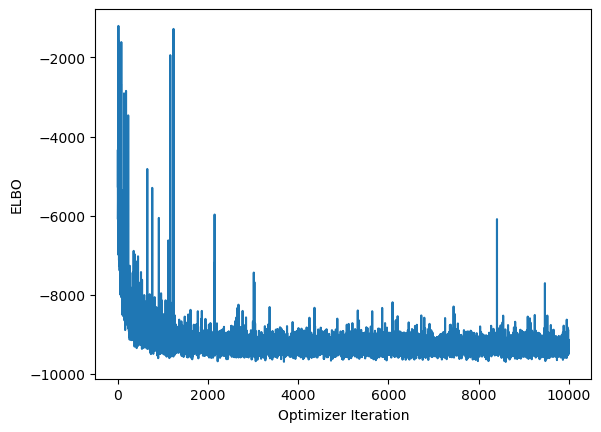

In [19]:
plt.plot(losses.numpy())
plt.xlabel('Optimizer Iteration')
plt.ylabel('ELBO')

In [20]:
s = surrogate_posterior.sample(1000)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2329dedbe0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2329dfa6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2329ded6a0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2329e0c160>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2329e0c6a0>,
 'means': []}

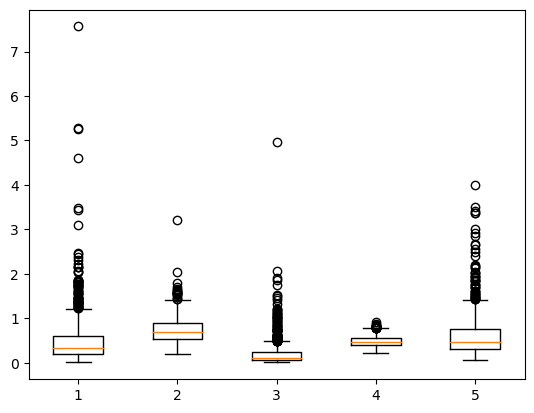

In [40]:
plt.boxplot(s['xi'].numpy())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2329d5a3d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2329d5a910>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2329d5a130>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2329d5ae50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2329d68130>,
 'means': []}

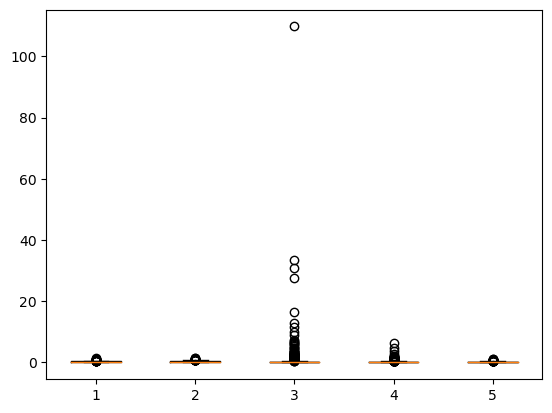

In [41]:
plt.boxplot(s['tau'].numpy())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f23298485b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2329848af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2329848310>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2329857070>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2329857310>,
 'means': []}

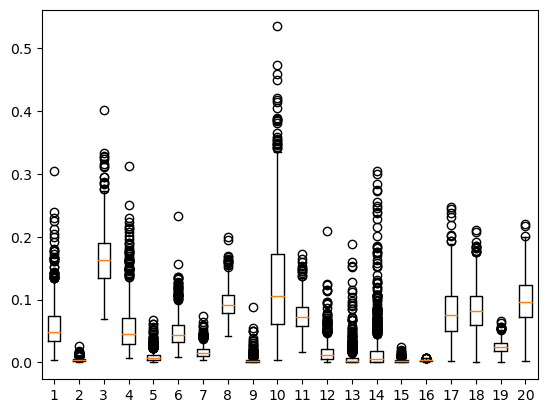

In [44]:
plt.boxplot(stickbreak(s['nu']).numpy())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2328e87640>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2328e87b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2328e873a0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2328e95100>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2328e953a0>,
 'means': []}

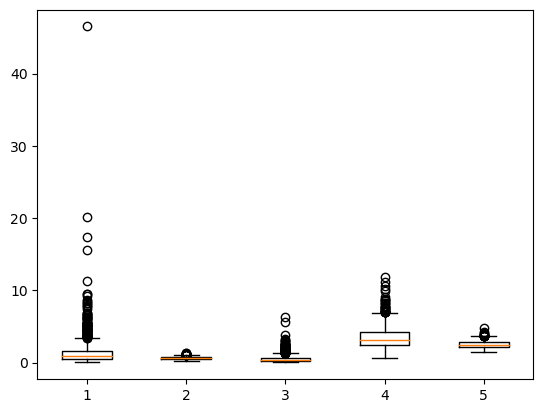

In [55]:
plt.boxplot(s['alpha'].numpy()[:,0])